### Kaggle RNN 手把手
1. 讀取資料
2. 資料預處理
3. 建立模型
4. 訓練模型
5. 評估模型準確率
6. 輸出成果

### 匯入套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

### 讀取資料

In [2]:
train = pd.read_csv('training_set.csv')
submit = pd.read_csv('sampleSubmission.csv')

In [3]:
print(train.shape)
print(submit.shape)

(74278, 7)
(30, 2)


In [4]:
train.head()

,Time,Weekday,Open,High,Low,Close,Volume
0,170 05:00:00,0,1.12053,1.12079,1.12050,1.12067,302.690002
1,170 05:10:00,0,1.12066,1.12074,1.12051,1.12070,486.690001
2,170 05:20:00,0,1.12070,1.12071,1.12065,1.12070,212.120000
3,170 05:30:00,0,1.12070,1.12072,1.12050,1.12061,811.989999
4,170 05:40:00,0,1.12060,1.12079,1.12027,1.12029,502.870001


In [5]:
train.shape

(74278, 7)

In [6]:
train.columns

Index(['Time', 'Weekday', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

### 資料預處理

In [7]:
train.isna().sum()

Time       0
Weekday    0
Open       0
High       0
Low        0
Close      0
Volume     0
dtype: int64

In [8]:
close = train['Close']
target_list = np.expand_dims(close.values,axis=1) # 展開維度成兩維 (總數,feature數)
# 也可以直接reshape(-1,1) X = X.values.reshape(-1,1)

In [9]:
target_list.shape

(74278, 1)

In [10]:
time = train['Time'].values

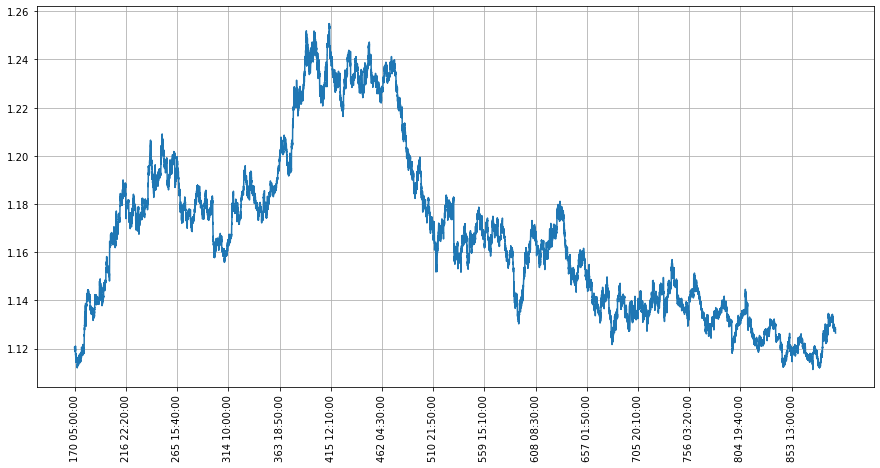

In [11]:
plt.figure(figsize = (15,7))
plt.plot(
    np.arange(len(close)),
    close,
    label = 'Close',
)
plt.xticks(np.arange(len(close))[::5000], train['Time'][::5000], rotation = 'vertical')
plt.grid()
plt.show()

In [12]:
train = train.drop(['Time','Weekday'], axis=1).values

In [13]:
def window_train (data, target, window_size,predict_length=1):
    X_train,y_train = [],[]
    for i in range(len(data) - (window_size+predict_length) + 1):
        X_train.append(data[i:i+window_size])
        y_train.append(target[i+window_size:i+window_size+predict_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train,y_train

In [14]:
window_size = 6
X,y = window_train(train, target_list, window_size,)

In [15]:
X.shape # (總數,window_size,feature數)

(74272, 6, 5)

In [16]:
y.shape

(74272, 1, 1)

In [17]:
# 0:Open,1:High,2:Low,3:Close,4:Volume
X = X[:,:,3]
X = X[:,:,np.newaxis]
print(X.shape)

(74272, 6, 1)


In [18]:
X_train = X[:70000]
y_train = y[:70000]

X_valid = X[70000:]
y_valid = y[70000:]

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_valid.shape))
print("y_test size: {}".format(y_valid.shape))

X_train size: (70000, 6, 1)
y_train size: (70000, 1, 1)
X_test size: (4272, 6, 1)
y_test size: (4272, 1, 1)


In [19]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.layers import TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

In [46]:
model = tf.keras.Sequential()
model.add(LSTM(units=36,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=36,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=36))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=1))

In [47]:
opt = Adam(lr=0.001, decay=1e-6, clipvalue=5) # https://wulc.me/2018/05/01/%E6%A2%AF%E5%BA%A6%E8%A3%81%E5%89%AA%E5%8F%8A%E5%85%B6%E4%BD%9C%E7%94%A8/

model.compile(loss='mae', optimizer=opt, metrics=['mae'])

In [48]:
model.fit(X_train, y_train, epochs=6, validation_data=(X_valid,y_valid))

Train on 70000 samples, validate on 4272 samples
Epoch 1/7
70000/70000 [==============================] - 78s 1ms/sample - loss: 0.0817 - mae: 0.0817 - val_loss: 0.0152 - val_mae: 0.0152
Epoch 2/7
70000/70000 [==============================] - 70s 998us/sample - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0037 - val_mae: 0.0037
Epoch 3/7
70000/70000 [==============================] - 70s 997us/sample - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0050 - val_mae: 0.0050
Epoch 4/7
70000/70000 [==============================] - 70s 996us/sample - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0051 - val_mae: 0.0051
Epoch 5/7
70000/70000 [==============================] - 70s 996us/sample - loss: 0.0041 - mae: 0.0041 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 6/7
70000/70000 [==============================] - 70s 997us/sample - loss: 0.0037 - mae: 0.0037 - val_loss: 0.0037 - val_mae: 0.0037
Epoch 7/7
70000/70000 [==============================] - 70s 996us/sample - loss: 0.0035 - mae: 0.0035 - val_loss

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                multiple                  5472      
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_7 (LSTM)                multiple                  10512     
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_8 (LSTM)                multiple                  10512     
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                 

In [50]:
valid_pred = model.predict(X_valid)

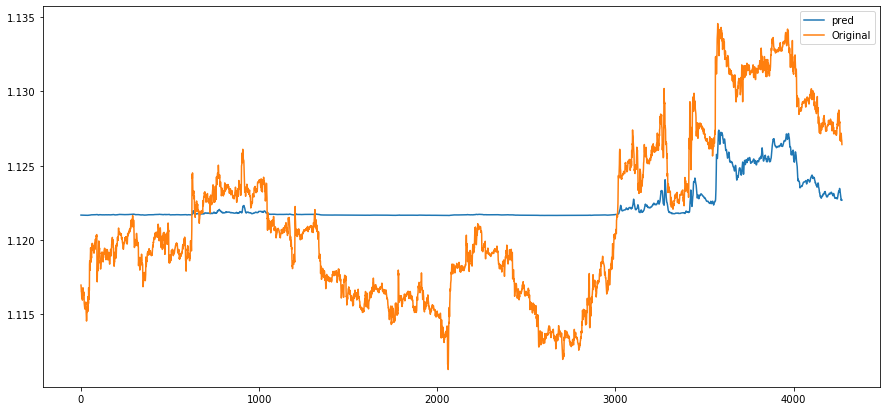

In [51]:
plt.figure(figsize=(15,7))
plt.plot(np.squeeze(valid_pred),label='pred')
plt.plot(np.squeeze(y_valid),label='Original')
plt.legend()
plt.show()

In [52]:
# 將資料最後一筆與預測值串接
test_data = np.array([i[0] for i in X[-1]])
print(test_data.shape)
print(test_data)

(6,)
[1.12704 1.12665 1.12719 1.12697 1.12676 1.12672]


In [53]:
test_data = np.append(test_data,y[-1])
print(test_data.shape)
print(test_data)

(7,)
[1.12704 1.12665 1.12719 1.12697 1.12676 1.12672 1.12643]


In [54]:
test_data[-len(test_data)+1+0:]

array([1.12665, 1.12719, 1.12697, 1.12676, 1.12672, 1.12643])

In [55]:
hey = test_data[0:len(test_data)-1]
hey0 = hey[np.newaxis,:]
hey1 = hey[np.newaxis,:,np.newaxis]
print(hey0.shape)
print(hey1.shape)

(1, 6)
(1, 6, 1)


In [56]:
for i in range(len(submit)):
    test_X_data = test_data[-len(test_data)+1+i:]
    print(test_X_data)
#     test_X_data = test_data[0:len(test_data)-1]
#     test_y_data = test_data[-1]
    
    # 將其reshape成三維shape
    test_X_data = test_X_data[np.newaxis,:,np.newaxis]
#     test_y_data = np.array([test_y_data])
#     test_y_data = test_y_data[np.newaxis,:,np.newaxis]

    print(i)
    test_pred = model.predict(test_X_data)
    print('pred: ',test_pred)
    # append 新預測至最後一筆
    test_data = np.append(test_data, test_pred)
    print('new data: ',test_data)

[1.12665 1.12719 1.12697 1.12676 1.12672 1.12643]
0
pred:  [[1.1226648]]
new data:  [1.12704    1.12665    1.12719    1.12697    1.12676    1.12672
 1.12643    1.12266481]
[1.12719    1.12697    1.12676    1.12672    1.12643    1.12266481]
1
pred:  [[1.1226687]]
new data:  [1.12704    1.12665    1.12719    1.12697    1.12676    1.12672
 1.12643    1.12266481 1.12266874]
[1.12697    1.12676    1.12672    1.12643    1.12266481 1.12266874]
2
pred:  [[1.1225439]]
new data:  [1.12704    1.12665    1.12719    1.12697    1.12676    1.12672
 1.12643    1.12266481 1.12266874 1.12254393]
[1.12676    1.12672    1.12643    1.12266481 1.12266874 1.12254393]
3
pred:  [[1.1224133]]
new data:  [1.12704    1.12665    1.12719    1.12697    1.12676    1.12672
 1.12643    1.12266481 1.12266874 1.12254393 1.12241328]
[1.12672    1.12643    1.12266481 1.12266874 1.12254393 1.12241328]
4
pred:  [[1.122246]]
new data:  [1.12704    1.12665    1.12719    1.12697    1.12676    1.12672
 1.12643    1.12266481 1.12

In [57]:
submit['Close'] = test_data[window_size+1:]

In [58]:
submit.to_csv('submission_LSTM_W.csv',index=0)